In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-ctscan-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F839140%2F1432479%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T041429Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D45ce57b824e44180c3187f9b1f2c5758ef308e9ec12a620a9de2c76d148f8872c71de97211a597e69fcb88620dac7a98d9f24d36a513b10f44eb664cd6b7c9894a131f3c878d0b0fa391461d01ae3b3810237804a5ebf1508fe8dfb531abbd0172a4dd546bf6ec2b8a5555f5a3455ecae38227aa5113facd8699fa0e6d9d29bcdf0f87cad86ad4c3f242f0d4b9063530682df627b96cd595db82c3c1a9207eafe37288584ee36831787d10cdbd8839344944d5d72aa0f0d61a68f05f4a87b93a13ece858c1aa444500fb9c770bbb39826f4b9a5699d5529dda05817a8d46e99933fa2e0ab26412247dce77103a1e42526932bb652530c64be1fce045acd4fb6a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 124379012 bytes downloaded
Downloaded and uncompressed: chest-ctscan-images
Data source import complete.


In [2]:
train_path = "../input/chest-ctscan-images/Data/train"
valid_path = "../input/chest-ctscan-images/Data/valid"
test_path = "../input/chest-ctscan-images/Data/test"

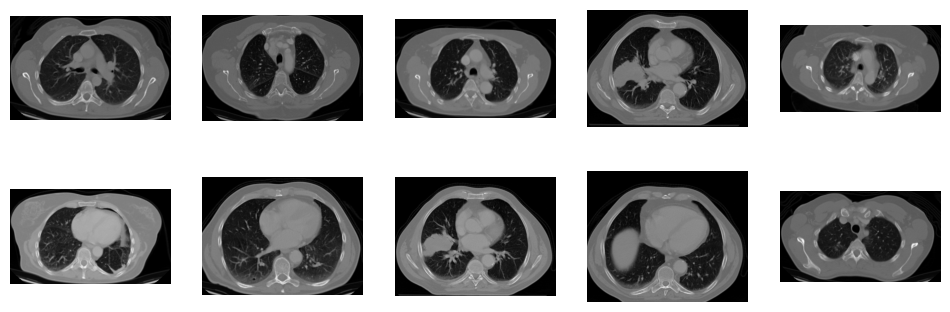

In [3]:
#chest CT-scans Visualize
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

def visualize_images(folder_path):
    image_files = os.listdir(folder_path)
    fig, ax = plt.subplots(2, 5, figsize=(12, 4))
    for i in range(2):
        for j in range(5):
            image_path = os.path.join(folder_path, random.choice(image_files))
            image = imread(image_path)
            ax[i, j].imshow(image, cmap='gray')
            ax[i, j].axis('off')
    plt.show()
folder_path = '/kaggle/input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
visualize_images(folder_path)

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, VGG16, ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [5]:
INPUT_SHAPE = (460,460,3)
NUM_CLASSES=4
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(460,460),
    batch_size=32,
    class_mode='categorical',

)


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(460,460),
    batch_size=32,
    class_mode='categorical',
)
validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(460,460),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


USING **RESNET50**

In [6]:
#Using ResNet50
base_model = ResNet50(include_top=False,pooling='av',weights='imagenet',input_shape=(INPUT_SHAPE))
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES,activation='softmax'))
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 15, 15, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 batch_normalization (Batch  (None, 460800)            1843200   
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               117965056 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 10

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='Chest_CT_SCAN_ResNet50.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 1.8850 - accuracy: 0.3899
Epoch 1: val_loss improved from inf to 2.65701, saving model to Chest_CT_SCAN_ResNet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 62s 2s/step - loss: 1.8850 - accuracy: 0.3899 - val_loss: 2.6570 - val_accuracy: 0.3472
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 1.3832 - accuracy: 0.5791
Epoch 2: val_loss improved from 2.65701 to 2.14556, saving model to Chest_CT_SCAN_ResNet50.h5
20/20 [==============================] - 63s 3s/step - loss: 1.3832 - accuracy: 0.5791 - val_loss: 2.1456 - val_accuracy: 0.4583
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.1648 - accuracy: 0.6232
Epoch 3: val_loss improved from 2.14556 to 1.55918, saving model to Chest_CT_SCAN_ResNet50.h5
20/20 [==============================] - 48s 2s/step - loss: 1.1648 - accuracy: 0.6232 - val_loss: 1.5592 - val_accuracy: 0.5694
Epoch 4/30
20/20 [==============================] - ETA: 0s - loss: 0.9918 - accuracy: 0.6688
Epoch 4: val_loss improved from 1.55918 to 1.10056, saving model to Chest_CT_SCAN_ResNet50.h5
20/20 [==============================] - 57s 3s/s

In [9]:
result = model.evaluate(test_generator)

10/10 [==============================] - 11s 1s/step - loss: 0.5870 - accuracy: 0.8222


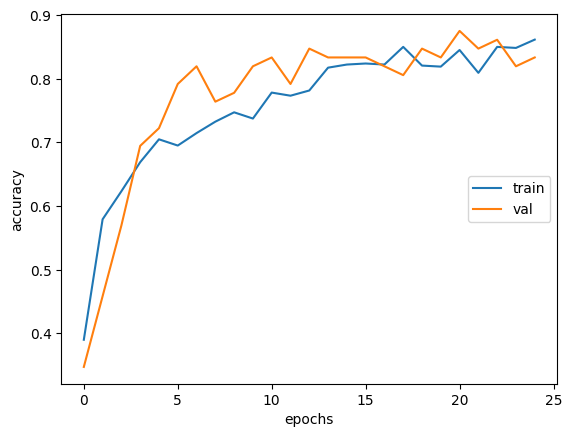

In [10]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Using **VGG16**

In [11]:
vgg_model= VGG16(include_top = False,pooling='avg',weights='imagenet',input_shape=(INPUT_SHAPE))

for layer in vgg_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES,activation='softmax'))
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 15, 15, 2048)      23587712  
                                                                 
 flatten_1 (Flatten)         (None, 460800)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 460800)            1843200   
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               117965056 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='Chest_CT_SCAN_VGG16.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 1.8744 - accuracy: 0.4470
Epoch 1: val_loss improved from inf to 4.46969, saving model to Chest_CT_SCAN_VGG16.h5
20/20 [==============================] - 55s 3s/step - loss: 1.8744 - accuracy: 0.4470 - val_loss: 4.4697 - val_accuracy: 0.4444
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 1.4806 - accuracy: 0.5661
Epoch 2: val_loss improved from 4.46969 to 3.34323, saving model to Chest_CT_SCAN_VGG16.h5
20/20 [==============================] - 54s 3s/step - loss: 1.4806 - accuracy: 0.5661 - val_loss: 3.3432 - val_accuracy: 0.3472
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.2952 - accuracy: 0.5775
Epoch 3: val_loss improved from 3.34323 to 2.29959, saving model to Chest_CT_SCAN_VGG16.h5
20/20 [==============================] - 52s 3s/step - loss: 1.2952 - accuracy: 0.5775 - val_loss: 2.2996 - val_accuracy: 0.4306
Epoch 4/30
20/20 [==============================] - ETA: 0s - 

In [14]:
result = model.evaluate(test_generator)

10/10 [==============================] - 6s 589ms/step - loss: 0.7364 - accuracy: 0.7778


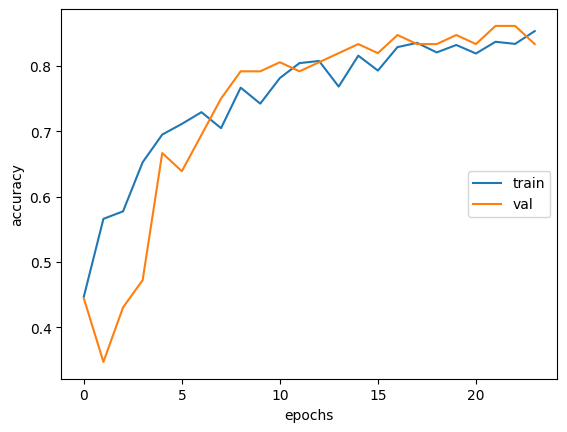

In [15]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = model.evaluate(test_generator)

In [ ]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [16]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-ctscan-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F839140%2F1432479%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T050917Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3dd67fcfe56cfbbd63d68e0c144e25d4f71ec0e5519287a7d0ef6c34554c54fc39590a4835e7938d4c6739706752012ecf3c1d09de9b4fd504c6e20b7121fff752d6c7d4c5173247ee13bece03756bab9660077f64ad566bc52cba2fd9fb5f98b1803c78e4c878608f7e7404e22a205c96463aead1c91054e6ffeb0883b789a6c01ddf105f4e0568af9f372dc1be7b4a8576a1729d791640100b3a1e433ee82651102347dd3d0cf8e0aef543ee22b65e7d477cb6639e673cf60a20e7ef4990d95697ece4b9386a97d588dde815708854c3471f69ea3fbf0a38e11508faca84c9d9a1829135a0436f49f7c7f1bc2ed38ec3200d6cda5874d3d1334a2c19f37956'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 124379012 bytes downloaded
Downloaded and uncompressed: chest-ctscan-images
Data source import complete.


In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import (
    EfficientNetB0,
    EfficientNetB1,
    EfficientNetB2,
    EfficientNetB3,
    EfficientNetB4,
    EfficientNetB5,
    EfficientNetB6,
    EfficientNetB7
)
from tensorflow.keras.applications.efficientnet import preprocess_input

In [18]:
path = "../input/chest-ctscan-images/Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

../input/chest-ctscan-images/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
../input/chest-ctscan-images/Data/train/normal
../input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
../input/chest-ctscan-images/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


In [19]:
train_path = "../input/chest-ctscan-images/Data/train"
test_path = "../input/chest-ctscan-images/Data/test"

In [20]:
# Helper-function for joining a directory and list of filenames.
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]
# Helper-function for plotting images
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(15,15))

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [21]:

from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):

    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    print(cm)

    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [22]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [23]:
# Function for calculating the predicted classes of the entire test-set and calling
# the above function to plot a few examples of mis-classified images.
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    test_generator.reset()

    # Predict the classes for all images in the test-set.
    y_pred = model.predict(test_generator, steps=STEPS_TEST)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)

    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [24]:
# Helper-function for loading images
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [25]:
# Set some important constants here
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 5

In [26]:
# ImageDataGenerator is needed because the dataset has no many data.
# The data augmentation can be useful to generate many augmented images from a single image

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'categorical')

# test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [27]:
# save some values to be used later

cls_train = train_generator.classes
cls_test = test_generator.classes
class_names = list(train_generator.class_indices.keys())
print(class_names)
num_classes = train_generator.num_classes
print("num classes:",num_classes)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
num classes: 4


In [28]:
image_paths_train = path_join(train_path, train_generator.filenames)
image_paths_test = path_join(test_path, test_generator.filenames)

In [29]:
STEPS_TEST = test_generator.n / BATCH_SIZE
STEPS_TEST

63.0

In [30]:
res_model = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))


16705208/16705208 [==============================] - 0s 0us/step


In [31]:
for layer in res_model.layers:
    if 'block7' not in layer.name:
        layer.trainable = False

In [32]:
# Check if all layers except block7 layers are not trainable
for i, layer in enumerate(res_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_3 - False
1 rescaling - False
2 normalization - False
3 rescaling_1 - False
4 stem_conv_pad - False
5 stem_conv - False
6 stem_bn - False
7 stem_activation - False
8 block1a_dwconv - False
9 block1a_bn - False
10 block1a_activation - False
11 block1a_se_squeeze - False
12 block1a_se_reshape - False
13 block1a_se_reduce - False
14 block1a_se_expand - False
15 block1a_se_excite - False
16 block1a_project_conv - False
17 block1a_project_bn - False
18 block2a_expand_conv - False
19 block2a_expand_bn - False
20 block2a_expand_activation - False
21 block2a_dwconv_pad - False
22 block2a_dwconv - False
23 block2a_bn - False
24 block2a_activation - False
25 block2a_se_squeeze - False
26 block2a_se_reshape - False
27 block2a_se_reduce - False
28 block2a_se_expand - False
29 block2a_se_excite - False
30 block2a_project_conv - False
31 block2a_project_bn - False
32 block2b_expand_conv - False
33 block2b_expand_bn - False
34 block2b_expand_activation - False
35 block2b_dwconv - False
36 blo

In [33]:
model = Sequential()
model.add(res_model)
# model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(N_CLASSES, activation = 'softmax'))

In [34]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4059815 (15.49 MB)
Trainable params: 724916 (2.77 MB)
Non-trainable params: 3334899 (12.72 MB)
_________________________________________________________________


In [35]:
checkpoint = ModelCheckpoint(filepath='./chest_CT_SCAN-EfficientNet.h5',
                            monitor='val_loss',
                            mode='auto',
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=3)

In [36]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    verbose = 1,
                    validation_data = test_generator,
                    validation_steps = 50,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 1.2833 - acc: 0.5823

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 22s 101ms/step - loss: 1.2833 - acc: 0.5823 - val_loss: 0.9070 - val_acc: 0.6400
Epoch 2/20
100/100 [==============================] - 6s 63ms/step - loss: 0.5946 - acc: 0.7992 - val_loss: 0.5645 - val_acc: 0.7160
Epoch 3/20
100/100 [==============================] - 6s 56ms/step - loss: 0.4201 - acc: 0.8614 - val_loss: 0.5211 - val_acc: 0.7680
Epoch 4/20
100/100 [==============================] - 4s 45ms/step - loss: 0.4281 - acc: 0.8474 - val_loss: 0.8231 - val_acc: 0.7240
Epoch 5/20
100/100 [==============================] - 6s 60ms/step - loss: 0.3533 - acc: 0.8855 - val_loss: 0.3491 - val_acc: 0.8880
Epoch 6/20
100/100 [==============================] - 6s 58ms/step - loss: 0.3043 - acc: 0.8976 - val_loss: 0.7816 - val_acc: 0.7360
Epoch 7/20
100/100 [==============================] - 7s 66ms/step - loss: 0.2617 - acc: 0.9036 - val_loss: 0.6436 - val_acc: 0.8120
Epoch 8/20
100/100 [==============================] - 5s 50ms/step - loss: 0.3

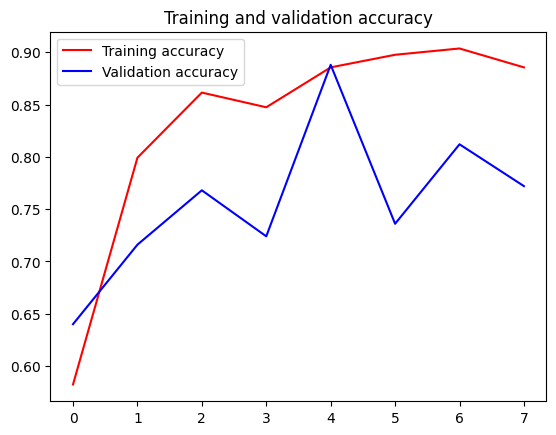

<Figure size 640x480 with 0 Axes>

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [38]:
result = model.evaluate(test_generator)

63/63 [==============================] - 2s 32ms/step - loss: 0.7617 - acc: 0.7651
